In [2]:
import sys
sys.path.append('../')
from plot_config import *
%matplotlib inline

import numpy as np

def euler_sim(M, x0 ,dt, T, Perturbation=None):
    t_range = np.linspace(0, T, int(T/dt))[:-1]
    X = np.zeros((len(t_range)+1, 3), dtype=np.complex128)
    X[0] = x0
    # If statements outside the loop for performance!
    if Perturbation is not None:
        for i, t in enumerate(t_range):
            X[i+1] = X[i] + 1j * (M+Perturbation(t)) @ X[i] *dt
    else:
        for i, t in enumerate(t_range):
            X[i+1] = X[i] + 1j*dt*M @ X[i]

    return X

def rk4_sim(M, x0, dt, T, Perturbation=None):

    t_range = np.linspace(0, T, int(T/dt))[:-1]
    X = np.zeros((len(t_range)+1, 3), dtype=np.complex128)
    X[0] = x0
    if Perturbation is not None:
        for i, t in enumerate(t_range):
            k1 = 1j * (M+Perturbation(t)) @ X[i]
            k2 = 1j * (M+Perturbation(t+dt/2)) @ (X[i] + k1*dt/2)
            k3 = 1j * (M+Perturbation(t+dt/2)) @ (X[i] + k2*dt/2)
            k4 = 1j * (M+Perturbation(t+dt)) @ (X[i] + k3*dt)
            X[i+1] = X[i] + (k1 + 2*k2 + 2*k3 + k4)*dt/6
    else:
        for i, t in enumerate(t_range):
            k1 = 1j * M @ X[i]
            k2 = 1j * M @ (X[i] + k1*dt/2)
            k3 = 1j * M @ (X[i] + k2*dt/2)
            k4 = 1j * M @ (X[i] + k3*dt)
            X[i+1] = X[i] + (k1 + 2*k2 + 2*k3 + k4)*dt/6

    return X

def implicit_euler_sim(M,x0,dt , T, Perturbation = None):

    t_range = np.linspace(0, T, int(T/dt))[:-1]
    X = np.zeros((len(t_range)+1, 3), dtype=np.complex128)
    X[0] = x0
    if Perturbation is not None:
        for i, t in enumerate(t_range):
            X[i+1] = np.linalg.solve(np.eye(M.shape[0])-1j*dt*(M+Perturbation(t)), X[i])
    else:
        for i, t in enumerate(t_range):
            X[i+1] = np.linalg.solve(np.eye(M.shape[0])-1j*dt*M, X[i])


    return X

In [3]:
#constants
from scipy.constants import physical_constants as pc
aut = pc['atomic unit of time'][0]
E = 200*1e-6 / pc['atomic unit of energy'][0] #uJ


tau_p = 5*1e-9 / aut #ns
t_0 = 10*1e-9 / aut #ns
w_0 = 0.5*1e-3 / pc['atomic unit of length'][0] #mm

mu_i_phi = np.sqrt(0.1)*0.15324673 # au
mu_i_psi = np.sqrt(0.2)*0.09692173 #au

E_i_phi = 5000*1e2 * pc["atomic unit of length"][0]  #cm^-1
E_i_psi = 5000*1e2 * pc["atomic unit of length"][0] #cm^-1
Gamma_diss = 25*1e2 * pc["atomic unit of length"][0] #cm^-1

#


In [4]:
def intensity(t):
    return 2*E/(tau_p * np.pi* w_0**2)*2**(-4*((t-t_0)/(tau_p))**2)

def Omega_if(t, mu):
    return mu*np.sqrt(intensity(t))

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#plot interactivley



def plot_sim(M, x0, dt, T, algo = euler_sim,  Perturbation=None, plots=None, linestyle='-', pad_strat = 'edge', pad_len = 1e5):
    """
    plot_sim Executes a simulation and plots the results

    Args:
        M (_type_): Propagation matrix
        x0 (_type_): Initial state
        dt (_type_): Time step size
        T (_type_): Total time
        algo (_type_, optional): Alogirthm to run. Defaults to euler_sim.
        Perturbation (_type_, optional): Time dependent perturbation matrix function. Defaults to None.
        plots (_type_, optional): Existing plots to add onto. Defaults to None.
        linestyle (str, optional): linestyle. Defaults to '-'.
        pad_strat (str, optional): padding strategy. Defaults to 'edge'.
        pad_len (_type_, optional): padding length. Defaults to 1e5.

    Returns:
        _type_: _description_
    """
    no_to_state = {
        0: r"i",
        1: r"\varphi",
        2: r"\psi_e"
    }
    if plots is None:
        fig, ax = plt.subplots()
        fig_fft, ax_fft = plt.subplots()
    else:
        fig, ax, fig_fft, ax_fft = plots

    pad_len = int(pad_len)


    X = algo(M, x0, dt, T, Perturbation)
    t = np.linspace(0, T, int(T/dt))


    X = np.pad(X,[(pad_len,pad_len),(0,0)],pad_strat)

    t = np.linspace(-dt*pad_len, T+dt*pad_len, int(T/dt)+ pad_len*2)

    # plot all the states
    for i in range(X.shape[1]):
        ax.plot(t,np.abs(X[:,i]), label=f"$|{no_to_state[i]} \\rangle$ - RK4", linestyle=linestyle)
    ax.legend()

    # plot the fourier transform
    W = np.fft.fft(X, axis=0)
    # move fft
    #W = np.fft.fftshift(W, axes=0)
    # get axis scaling
    freq = np.fft.fftfreq(W.shape[0], d=dt)
    # plot

    W_max = np.max(np.abs(W))
    for i in range(W.shape[1]):
        freq_amplitude = np.abs(W[:,i])
        freq_amplitude = freq_amplitude/W_max

        ax_fft.plot(freq,freq_amplitude, label=f"$|{no_to_state[i]} \\rangle$ - RK4", linestyle=linestyle)

    ax_fft.legend()

    ax_fft.set_xlim((-0.75*1e-7,0.25*1e-7))
    # add axis labels

    ax.set_xlabel("Time $\hbar/E_H$")
    ax.set_ylabel("Population")
    ax_fft.set_xlabel("Frequency ($E_H/\hbar$)")
    ax_fft.set_ylabel("Population arb. u.")

    results = [X,t,W, freq]

    return (fig, ax, fig_fft, ax_fft), results


def compare_algos(M, x0, dt, T, Perturbation=None):
    #plots, results_euler = plot_sim(M, x0, dt, T, euler_sim, Perturbation, linestyle='--')
    plots = None
    _, results_rk4 = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='-', pad_len=0)
    plt.show()

    #plots, results_rk42 = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=None, linestyle='-.')
    #plt.show()

    results_euler = None #TODO: remove
    return results_euler, results_rk4


#results_euler, results_rk4 = compare_algos(M, np.array([1, 0, 0]), 0.001e-9/aut, 100e-9/aut, laser)


def compare_padding_strats(M,x0,dt,T, Perturbation=None):
    plots = None
    plots_wrap, wrap = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='-', pad_strat='wrap', pad_len=1e5)
    plots_edge, edge = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='-', pad_strat='edge', pad_len=1e5)
    plots_zero, zero = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='-', pad_strat='constant', pad_len=1e5)

    #save the plots
    fig, ax, fig_fft, ax_fft = plots_wrap
    fig.savefig("wrap_td.png")
    fig_fft.savefig("wrap_fd.png")

    fig, ax, fig_fft, ax_fft = plots_edge
    fig.savefig("edge_td.png")
    fig_fft.savefig("edge_fd.png")

    fig, ax, fig_fft, ax_fft = plots_zero
    fig.savefig("zero_td.png")
    fig_fft.savefig("zero_fd.png")

    return

# compare_padding_strats(M, np.array([1, 0, 0]), 0.001e-9/aut, 100e-9/aut, laser)

In [6]:

x0 = np.array([1, 0, 0])
dt = 0.000005e-9/aut
T = 50e-9/aut

def calc_dissoc_yield(omega, q):
    E_i = -omega
    E_phi = E_i_phi - omega
    E_psi = E_i_psi - omega + 1j* Gamma_diss/2
    g_phipsi = 0

    #laser
    laser = lambda t: np.array(
        [
            [0, np.conjugate(Omega_if(t,mu_i_phi)), np.conjugate(Omega_if(t,mu_i_psi))],
            [Omega_if(t,mu_i_phi), 0, 0],
            [Omega_if(t,mu_i_psi), 0, 0],
        ]
    )

    M = np.array(
        [
            [E_i, 0,0],
            [0, E_phi, np.conjugate(g_phipsi)],
            [0, g_phipsi, E_psi],
        ]
    )

    Perturbation = laser

    X = rk4_sim(M, x0, dt, T, Perturbation)

    q.put(X)


In [7]:
from multiprocessing import Process, Queue
import os
PROJECT_DIR = os.path.abspath('')
X_cache_dir = os.path.join('/scratch/islerd/x_cache')
os.makedirs(X_cache_dir, exist_ok=True)

threads = []
omega_range = np.linspace(-1.25*E_i_phi, 1.25*E_i_phi, 60)
# Dictionary with omega_range values as keys
dissoc_yields = {omega: None for omega in omega_range}
for omega in omega_range:
    q = Queue()
    p = Process(target=calc_dissoc_yield, args=(omega,q,))
    threads.append((p, q, omega))

num_threads_max = 20
num_threads_running = 0
running_threads = []


first = True
while len(threads) > 0:
    if num_threads_running >= num_threads_max or len(threads) == 0:
        # Wait until a thread finishes
        for thread in running_threads:
            # dissoc_yield = thread[1].get()
            X = thread[1].get()
            # Store X to disk
            np.savetxt(os.path.join(X_cache_dir, f'X_{str(thread[2]*1e10)}_dt_{round(dt)}.txt'), X)
            dissoc_yield = 1 - np.max(np.abs(X[-10000:-1,0])**2)
            print(f'Saved for omega={thread[2]}')
            thread[0].join()
            dissoc_yields[thread[2]] = dissoc_yield
            running_threads.remove(thread)
            num_threads_running -= 1
    else:
        for i in range(num_threads_max - num_threads_running):
            if len(threads) == 0:
                break
            thread = threads.pop(0)
            thread[0].start()
            print(f"Thread for omega={thread[2]} started")
            num_threads_running += 1
            running_threads.append(thread)

# Wait for the remaining threads to finish
for thread in running_threads:
    X = thread[1].get()
    # Store X to disk
    np.savetxt(os.path.join(X_cache_dir, f'X_{str(thread[2]*1e10)}_dt_{round(dt)}.txt'), X)
    dissoc_yield = 1 - np.max(np.abs(X[-10000:-1,0])**2)
    print(f'Saved for omega={thread[2]}')
    thread[0].join()
    dissoc_yields[thread[2]] = dissoc_yield

Thread for omega=-3.30735756814375e-05 started
Thread for omega=-2.7985333268908652e-05 started
Thread for omega=-2.2897090856379807e-05 started
Thread for omega=-1.780884844385096e-05 started
Thread for omega=-1.2720606031322114e-05 started
Thread for omega=-7.632363618793269e-06 started


Thread for omega=-2.544121206264421e-06 started


TypeError: savetxt() missing 1 required positional argument: 'X'

(6000000, 3)


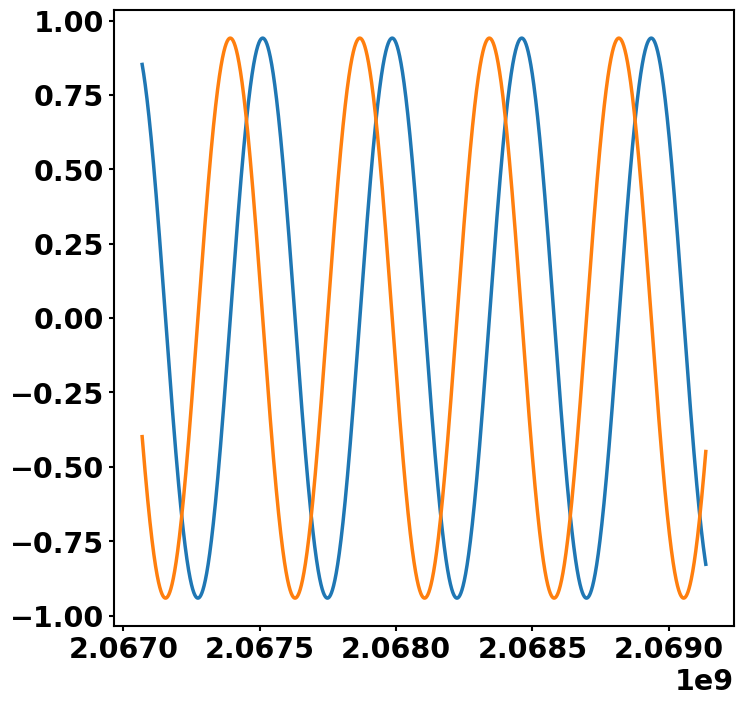

In [ ]:
# t = np.linspace(0, T, int(T/dt))
print(X.shape)
plt.plot(t[5000000:5005000], np.real(X[:, 0][5000000:5005000]), label="Real")
plt.plot(t[5000000:5005000], np.imag(X[:, 0][5000000:5005000]), label="Imag")
plt.show()

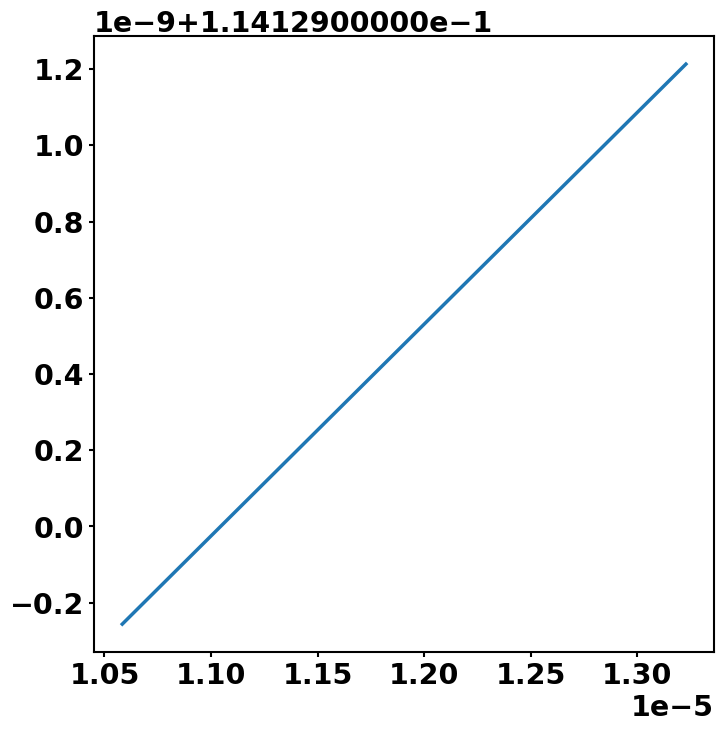

In [ ]:
# Plot the results
plt.plot(omega_range, list(dissoc_yields.values()))
plt.savefig(os.path.join(PROJECT_DIR, 'fano.png'))
print('Finished successfully')